March Madness ML Project

In [147]:
# lib imports copied from lab 4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Load the LinearRegression class from scikit-learn's linear_model module
# Also load the PolynomialFeatures transformer and OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [148]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format


In [149]:
RSDR = "mens-march-mania-2022\MDataFiles_Stage1\MRegularSeasonDetailedResults.csv"
Teams = "mens-march-mania-2022\MDataFiles_Stage1\MTeams.csv"
# For the fisrt iteration lets omit the seeds
Seeds = "mens-march-mania-2022\MDataFiles_Stage1\MNCAATourneySeeds.csv"
SeedRoundSlots = "mens-march-mania-2022\MDataFiles_Stage1\MNCAATourneySeedRoundSlots.csv"
RSCR = "mens-march-mania-2022\MDataFiles_Stage1\MRegularSeasonCompactResults.csv"

ConferenceTourney = "mens-march-mania-2022\MDataFiles_Stage1\MConferenceTourneyGames.csv"
MasseyOrd = "mens-march-mania-2022\MDataFiles_Stage1\MMasseyOrdinals.csv"
Coaches = "mens-march-mania-2022\MDataFiles_Stage1\MTeamCoaches.csv"
TeamConferences = "mens-march-mania-2022\MDataFiles_Stage1\MTeamConferences.csv"


# All databases that could potentially have usable data
RSDR = pd.read_csv(RSDR, na_values = ["?"]).dropna()
Teams = pd.read_csv(Teams, na_values = ["?"]).dropna()
Seeds = pd.read_csv(Seeds, na_values = ["?"]).dropna()
SeedRoundSlots = pd.read_csv(SeedRoundSlots, na_values = ["?"]).dropna()

ConferenceTourney = pd.read_csv(ConferenceTourney, na_values = ["?"]).dropna()
MasseyOrd = pd.read_csv(MasseyOrd, na_values = ["?"]).dropna()
Coaches = pd.read_csv(Coaches, na_values = ["?"]).dropna()

RSCR = pd.read_csv(RSCR, na_values = ['?']).dropna()

# RSDR.info()
RSDR.head()
# Teams.info()
# Teams.head()
# ConferenceTourney.info()
# ConferenceTourney.head()
# MasseyOrd.info()
# MasseyOrd.head(20)
# Coaches.info()
# Coaches.head(20)

# Due to player turn over we want to limit the data to "more recent" data of 2015 and onward and reset the index
RSDR = RSDR[(RSDR['Season'] > 2015)].reset_index()
RSDR.drop(['index'], axis= 1, inplace= True)
MasseyOrd = MasseyOrd[(MasseyOrd['Season'] > 2015)].reset_index()
MasseyOrd.drop(['index'], axis= 1, inplace= True)
Seeds = Seeds[(Seeds['Season'] > 2015)].reset_index()
Seeds.drop(['index'], axis= 1, inplace= True)

# Need to replace the location objects with random number values
RSCR['WLoc'].replace({'H' : 0, 'A' : 1, 'N' : 2}, inplace = True)

# RSCR['LLoc'] = RSCR[RSCR['WLoc'].replace({0 : 1, 1 : 0, 2 : 2}, inplace = True)]
RSCR['LLoc'] = RSCR['WLoc']

RSCR['LLoc'].replace({0 : 1, 1 : 0}, inplace = True)

RSCR.head()

#Checking to see if we have any null values in the current semi-cleaned data set
# sns.heatmap(RSDR.isnull(), yticklabels= False, cbar= False, cmap= "viridis")
# sns.heatmap(MasseyOrd.isnull(), yticklabels= False, cbar= False, cmap= "viridis")
# sns.heatmap(Seeds.isnull(), yticklabels= False, cbar= False, cmap= "viridis")




,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,LLoc
0,1985,20,1228,81,1328,64,2,0,2
1,1985,25,1106,77,1354,70,0,0,1
2,1985,25,1112,63,1223,56,0,0,1
3,1985,25,1165,70,1432,54,0,0,1
4,1985,25,1192,86,1447,74,0,0,1


In [150]:
RSCR['NumOT'].value_counts()
# This happens irregularly so is likely insignificant to the data results.
# We can drop it
RSCR.drop(['NumOT', 'DayNum'], axis=1, inplace=True)
RSCR = RSCR[RSCR['Season'] >= 2016].reset_index(drop = True)
RSCR

,Season,WTeamID,WScore,LTeamID,LScore,WLoc,LLoc
0,2016,1104,77,1244,64,0,1
1,2016,1105,68,1408,67,1,0
2,2016,1112,79,1334,61,0,1
3,2016,1115,58,1370,56,1,0
4,2016,1116,86,1380,68,0,1
...,...,...,...,...,...,...,...
34546,2022,1400,79,1242,76,0,1
34547,2022,1411,66,1126,63,1,0
34548,2022,1422,68,1441,49,1,0
34549,2022,1438,69,1181,68,1,0


In [151]:
# Create a new column with the difference in points between winning and loosing team
RSCR['WinMargin'] = RSCR['WScore'] - RSCR['LScore']
RSCR.head()

,Season,WTeamID,WScore,LTeamID,LScore,WLoc,LLoc,WinMargin
0,2016,1104,77,1244,64,0,1,13
1,2016,1105,68,1408,67,1,0,1
2,2016,1112,79,1334,61,0,1,18
3,2016,1115,58,1370,56,1,0,2
4,2016,1116,86,1380,68,0,1,18


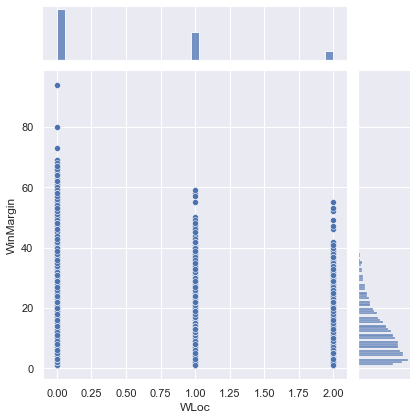

In [152]:
# Breif data exploration
sns.jointplot(x='WLoc',y='WinMargin',data=RSCR)

In [153]:
# sns.heatmap(RSCR.drop(['WTeamID', 'LTeamID'], axis=1), yticklabels=False, cbar=False, cmap='viridis')


In [154]:
winners = RSCR.groupby(['Season', 'WTeamID']).count().reset_index()
winners = winners[['Season', 'WTeamID']].rename(columns={'WTeamID': "TeamID"})
winners.head()


,Season,TeamID
0,2016,1101
1,2016,1102
2,2016,1103
3,2016,1104
4,2016,1105


In [155]:
lossers = RSCR.groupby(['Season', 'LTeamID']).count().reset_index()
lossers = lossers[['Season', 'LTeamID']].rename(columns={'LTeamID': "TeamID"})
lossers.head()

,Season,TeamID
0,2016,1101
1,2016,1102
2,2016,1103
3,2016,1104
4,2016,1105


In [156]:
# Create an empty train dataset.
team_stats = pd.concat([winners, lossers], axis = 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop = True)
team_stats.head()

,Season,TeamID
0,2016,1101
1,2016,1102
2,2016,1103
3,2016,1104
4,2016,1105


In [157]:

# Creating aggregated features...

winner_team_stats = RSCR.groupby(['Season', 'WTeamID']).agg(TotalWins     = ('WTeamID', 'count'), 
                                                            AvgWinMargin  = ('WinMargin', 'mean'),
                                                            W_TotalPoints = ('WScore', 'sum'),
                                                            W_MaxPoints   = ('WScore', 'max'),
                                                            W_MinPoints   = ('WScore', 'min')
                                                            )
winner_team_stats = winner_team_stats.reset_index().rename(columns={"WTeamID": "TeamID"})
winner_team_stats.head()

,Season,TeamID,TotalWins,AvgWinMargin,W_TotalPoints,W_MaxPoints,W_MinPoints
0,2016,1101,9,7.56,704,91,62
1,2016,1102,12,5.83,850,97,61
2,2016,1103,25,12.52,1975,92,62
3,2016,1104,18,7.94,1280,105,51
4,2016,1105,10,8.50,727,85,54


In [158]:
losser_team_stats = RSCR.groupby(['Season', 'LTeamID']).agg(TotalLosses     = ('LTeamID', 'count'), 
                                                            AvgLossMargin  = ('WinMargin', 'mean'),
                                                            L_TotalPoints = ('LScore', 'sum'),
                                                            L_MaxPoints   = ('LScore', 'max'),
                                                            L_MinPoints   = ('LScore', 'min')
                                                            )
losser_team_stats = losser_team_stats.reset_index().rename(columns={"LTeamID": "TeamID"})
losser_team_stats.head()

,Season,TeamID,TotalLosses,AvgLossMargin,L_TotalPoints,L_MaxPoints,L_MinPoints
0,2016,1101,18,13.39,1182,100,51
1,2016,1102,18,14.17,1173,102,50
2,2016,1103,8,9.12,544,81,56
3,2016,1104,14,12.43,859,77,45
4,2016,1105,18,8.83,1152,78,52


In [159]:
team_stats = team_stats.merge(winner_team_stats, on = ['Season', 'TeamID'], how = 'left')
team_stats = team_stats.merge(losser_team_stats, on = ['Season', 'TeamID'], how = 'left')



In [160]:
team_stats
# team_stats.columns

,Season,TeamID,TotalWins,AvgWinMargin,W_TotalPoints,W_MaxPoints,W_MinPoints,TotalLosses,AvgLossMargin,L_TotalPoints,L_MaxPoints,L_MinPoints
0,2016,1101,9.00,7.56,704.00,91.00,62.00,18.00,13.39,"1,182.00",100.00,51.00
1,2016,1102,12.00,5.83,850.00,97.00,61.00,18.00,14.17,"1,173.00",102.00,50.00
2,2016,1103,25.00,12.52,"1,975.00",92.00,62.00,8.00,9.12,544.00,81.00,56.00
3,2016,1104,18.00,7.94,"1,280.00",105.00,51.00,14.00,12.43,859.00,77.00,45.00
4,2016,1105,10.00,8.50,727.00,85.00,54.00,18.00,8.83,"1,152.00",78.00,52.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2022,1468,9.00,10.67,671.00,85.00,66.00,11.00,16.55,661.00,70.00,50.00
2460,2022,1469,7.00,11.43,557.00,85.00,71.00,12.00,19.33,764.00,73.00,50.00
2461,2022,1470,8.00,11.12,565.00,83.00,57.00,13.00,11.77,767.00,84.00,50.00
2462,2022,1471,8.00,10.12,632.00,85.00,71.00,12.00,13.42,710.00,80.00,48.00


In [161]:
team_stats['WinRatio'] = team_stats['TotalWins'] / (team_stats['TotalWins'] + team_stats['TotalLosses'])
team_stats['AvgScoreMargin'] = ((team_stats['TotalWins'] * team_stats['AvgWinMargin'] - team_stats['TotalLosses'] * team_stats['AvgLossMargin']) / (team_stats['TotalWins'] + team_stats['TotalLosses']))
team_stats['PointsRatio'] = team_stats['W_TotalPoints'] / (team_stats['L_TotalPoints'] + team_stats['W_TotalPoints'])

team_stats


,Season,TeamID,TotalWins,AvgWinMargin,W_TotalPoints,W_MaxPoints,W_MinPoints,TotalLosses,AvgLossMargin,L_TotalPoints,L_MaxPoints,L_MinPoints,WinRatio,AvgScoreMargin,PointsRatio
0,2016,1101,9.00,7.56,704.00,91.00,62.00,18.00,13.39,"1,182.00",100.00,51.00,0.33,-6.41,0.37
1,2016,1102,12.00,5.83,850.00,97.00,61.00,18.00,14.17,"1,173.00",102.00,50.00,0.40,-6.17,0.42
2,2016,1103,25.00,12.52,"1,975.00",92.00,62.00,8.00,9.12,544.00,81.00,56.00,0.76,7.27,0.78
3,2016,1104,18.00,7.94,"1,280.00",105.00,51.00,14.00,12.43,859.00,77.00,45.00,0.56,-0.97,0.60
4,2016,1105,10.00,8.50,727.00,85.00,54.00,18.00,8.83,"1,152.00",78.00,52.00,0.36,-2.64,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2022,1468,9.00,10.67,671.00,85.00,66.00,11.00,16.55,661.00,70.00,50.00,0.45,-4.30,0.50
2460,2022,1469,7.00,11.43,557.00,85.00,71.00,12.00,19.33,764.00,73.00,50.00,0.37,-8.00,0.42
2461,2022,1470,8.00,11.12,565.00,83.00,57.00,13.00,11.77,767.00,84.00,50.00,0.38,-3.05,0.42
2462,2022,1471,8.00,10.12,632.00,85.00,71.00,12.00,13.42,710.00,80.00,48.00,0.40,-4.00,0.47


In [162]:
team_stats = team_stats[['Season', 'TeamID', 'WinRatio', 'AvgScoreMargin', 'PointsRatio']]
team_stats

,Season,TeamID,WinRatio,AvgScoreMargin,PointsRatio
0,2016,1101,0.33,-6.41,0.37
1,2016,1102,0.40,-6.17,0.42
2,2016,1103,0.76,7.27,0.78
3,2016,1104,0.56,-0.97,0.60
4,2016,1105,0.36,-2.64,0.39
...,...,...,...,...,...
2459,2022,1468,0.45,-4.30,0.50
2460,2022,1469,0.37,-8.00,0.42
2461,2022,1470,0.38,-3.05,0.42
2462,2022,1471,0.40,-4.00,0.47


25.571428571428573